# Temporal networks

In this notebook we show how to perform some basic operations on temporal graphs, reproducing the main plots appearing in the notes. Besides the classical packages, we will deploy some functions that are contained in the `Tnet.py` file whose content of this file is provided in the next notebook. If you want to run this notebook, create a folder named `src`, and add a file named `Tnet.py` with the codes insde of it.

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from copy import copy
import networkx as nx
import sys
from collections import Counter

sys.path.append('../')
from src.Tnet import *

import warnings
warnings.filterwarnings("ignore")

fig_directory = '../../Note/Notes/Figures/04_temporal/'

In [8]:
# load the datasets in the tij format
tij_school = pd.read_csv('../Data/SP/School_tij.csv')
tij_conference = pd.read_csv('../Data/SP/Conference_tij.csv')
tij_office = pd.read_csv('../Data/SP/Office_tij.csv')
tij_village = pd.read_csv('../Data/SP/Village_tij.csv')


# we print the first rows of one of these datasets to provide an example
tij_school.head()

,t,i,j,C1,C2
0,0.0,1170,1644,MP*1,MP*1
1,1.0,1170,1613,MP*1,MP*1
2,13.0,1170,1644,MP*1,MP*1
3,19.0,1181,1651,MP*1,MP*1
4,23.0,1108,1190,MP*1,MP*1


In [9]:
# load the datasets in the tijtau format
tijtau_school = pd.read_csv('../Data/SP/School_tijtau.csv')
tijtau_conference = pd.read_csv('../Data/SP/Conference_tijtau.csv')
tijtau_office = pd.read_csv('../Data/SP/Office_tijtau.csv')
tijtau_village = pd.read_csv('../Data/SP/Village_tijtau.csv')

# we print the first rows of one of these datasets to provide an example
tijtau_school.head()

,t,i,j,τ
0,205,600,609,1.0
1,208,600,609,6.0
2,245,600,609,1.0
3,254,600,609,1.0
4,279,600,609,2.0


### Create and plot the aggregated graph


We consider the `school` dataset and create its static aggregated version. We plot it, color-coding the nodes according to their class affiliation. As shown in the cell above, the dataframe `tij_school` contains two additional columns (`C1` and `C2`) that indicate the class to which `i` and `j` belong to, respectively.

In [10]:
# copy the tij_school in df. This is done for two reasons:
# * first, if you want to repeat the analysis on a different graph you only have to change the name once.
# * secondly, remember that when you x = y in python it is a copy by reference and not by name. Using the copy() command you avoid making modification to the original input variable.

df = copy(tij_school)

# add a weight column to the dataframe: in the tij representation all contacts have equal weight
df['w'] = 1

# aggregate the contact by the interacting indices
df = df.groupby(['i', 'j']).sum().reset_index()[['i', 'j', 'w']]
df.head()

,i,j,w
0,600,609,53
1,600,610,20
2,600,613,567
3,600,616,1
4,600,623,4


In the dataframe `df` we built, we removed the column `t` and substituted encoded in `w` the number of appearances of a single link. We now build a weighted adjacency matrix of this graph using the `scipy` package and then passing it to `networkx` to obtain the graph. To do so, we must first create a dictionary that converts the indices contained in `df` into integers between $1$ and $n$, where $n$ is the number of nodes.

In [11]:
# make a list of all nodes
all_nodes = np.unique(df[['i', 'j']])

# count how many nodes there are
n = len(all_nodes)

# create the dictionary between each node id and an integer
NodeMapper = dict(zip(all_nodes, np.arange(n)))

# map the nodes id to the integer
df.i = df.i.map(lambda x: NodeMapper[x])
df.j = df.j.map(lambda x: NodeMapper[x])

df.head()

,i,j,w
0,0,7,53
1,0,8,20
2,0,11,567
3,0,14,1
4,0,21,4


In [12]:
# convert the edge list into a sparse matrix: df.i, df.j are the coordinates of the non-zero entries of W and df.w is the value
W = csr_matrix((df.w, (df.i, df.j)), shape = (n,n))

# symmetrize the matrix
W = W + W.T

# build the graph from the matrix W
G = nx.from_scipy_sparse_array(W)

Now we plot

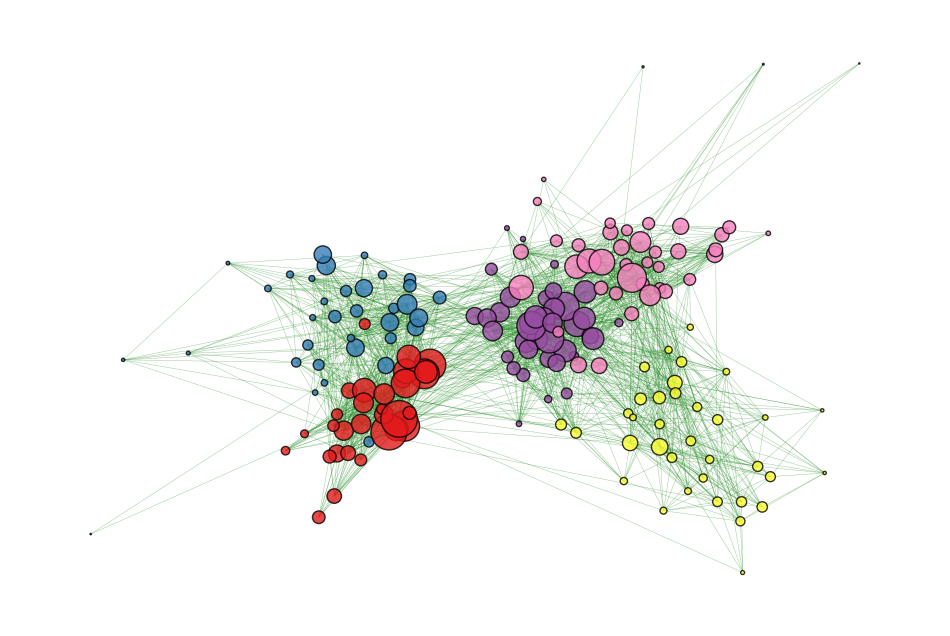

In [13]:
# this return a dictionary giving x and y coordinates of each node so that nodes that are more densely connected are close to one another and it results in a better plot
pos = nx.spring_layout(G)

# we set the node size proportional to the total interaction time 
node_size = 0.25*(W@np.ones(n))
edge_size = 0.3

# create the class label vector
classes = []

for node in all_nodes:
    _df = tij_school[tij_school.i == node]
    if len(_df) > 1:
        classes.append(_df.iloc[0].C1)

    else:
        _df = tij_school[tij_school.j == node]
        classes.append(_df.iloc[0].C2)

# plot functions      
all_classes = np.unique(classes)
ClassMapper = dict(zip(all_classes, np.arange(len(all_classes))))
norm = mpl.colors.Normalize(vmin = 0, vmax = len(all_classes))
cmap = cm.Set1
m = cm.ScalarMappable(norm = norm, cmap = cmap)
colors = [m.to_rgba(ClassMapper[c]) for c in classes]

plt.figure(figsize = (12,8))
nx.draw_networkx_edges(G, pos, alpha = 0.5, width = edge_size, edge_color = "forestgreen")
nx.draw_networkx_nodes(G, pos, node_size = node_size, node_color = colors, alpha = 0.8, edgecolors = 'k')
plt.axis('off')

# uncomment to save
# plt.savefig('Figures/graphPlot.pdf', bbox_inches = 'tight', dpi = 400)
plt.show();

## Reachability

As we mentioned in the course, the reachability (*i.e* the fraction of nodes that can be reached by a walk on a graph as a function of time) is small in temporal graphs than it is on static ones. Here we consider $4$ [SocioPatterns](http://www.sociopatterns.org/datasets/) and, for each of them, we compare the reachability over the first $8$ hours of measurement for the temporal graph and its aggregated counterpart.

In [28]:
T = 1440 # 8 hours (8*3600/20)
names = ['Conference', 'Office', 'School', 'Village']
dfv = [tij_conference, tij_office, tij_school, tij_village]

R, Ragg = [], []

for counter, tij in enumerate(dfv):

    print(f'Dataset: {names[counter]}')
    
    # select iteratively one of the four graphs and limit the observations to the first 8 hours
    df = copy(tij)
    df = df[['i', 'j', 't']]
    df = df[df.t < T]
    
    # create a mapping between the nodes and integers
    all_nodes = np.unique(df[['i', 'j']])
    n = len(all_nodes)
    NodeMapper = dict(zip(all_nodes, np.arange(n)))
    df.i = df.i.map(lambda x: NodeMapper[x])
    df.j = df.j.map(lambda x: NodeMapper[x])

    # compute the reachability vector 
    R.append(ComputeReachabilityVector(df, T))
    
    ################################################################
    
    # create the aggregated (unweighted) version of the graph
    df_g = df.groupby(['i', 'j']).mean().reset_index()
    W = csr_matrix((np.ones(len(df_g)), (df_g.i, df_g.j)), shape = (n,n))
    W = W + W.T + diags(np.ones(n))
    Wt = [W for t in range(T)]

    # compute the reachability vector
    Ragg.append(ReachabilityFromAdjacencyList(Wt))

Dataset: Conference
Dataset: Office
Dataset: School
Dataset: Village


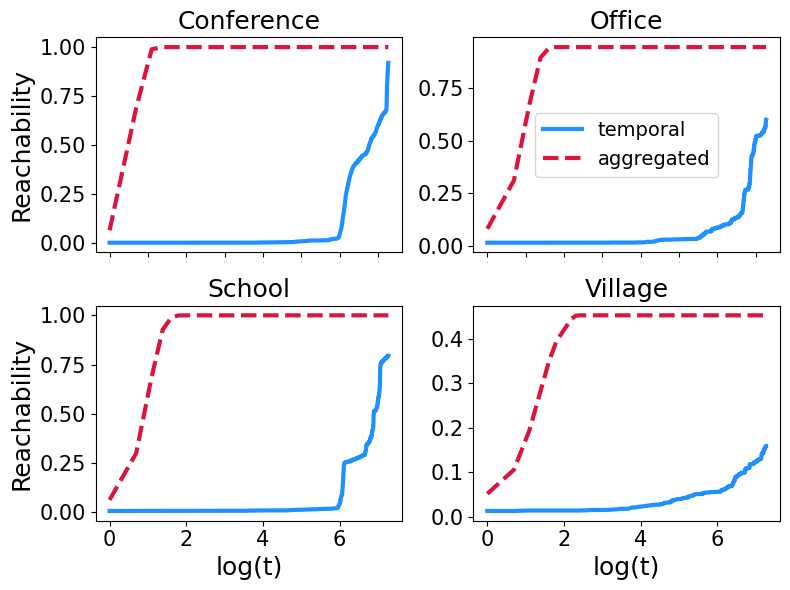

In [29]:
# PLOT
fig, ax = plt.subplots(2,2, figsize = (8, 6))
tv = np.arange(T)

for counter in range(4):

    a, b = int(counter/2), counter%2
    ax[a,b].plot(np.log(tv+1), R[counter], color = 'dodgerblue', label = 'temporal', linewidth = 3)
    ax[a,b].plot(np.log(tv+1), Ragg[counter], color = 'crimson', linestyle = '--', label = 'aggregated',
                linewidth = 3)
    
    if b == 0:
        ax[a,b].set_ylabel('Reachability', fontsize = 18)
        
    if a == 1:
        ax[a,b].set_xlabel('log(t)', fontsize = 18)
        ax[a, b].tick_params(axis = 'x', labelsize = 15)
    else:
        ax[a,b].tick_params(axis = 'x', labelsize = 0)
        
    ax[a,b].tick_params(axis = 'y', labelsize = 15)
    ax[a,b].set_title(names[counter], fontsize = 18)
    
ax[0,1].legend(fontsize = 14)
    
plt.tight_layout()

# uncomment to save
# plt.savefig('Figures/tnet_reachability.pdf', bbox_inches = 'tight', dpi = 400)
plt.show();

## Contact duration and interevent statistics

We now look at the distribution of the event duration and of the interevent duration. 

In [30]:
names = ['School', 'Conference', 'Office', 'Village']
dfv = [tijtau_school, tijtau_conference, tijtau_office, tijtau_village]

intervals = []

for i, df in enumerate(dfv):
    print(names[i])
    intervals.append(ComputeIntereventStatistic(copy(df)))
    print('\n')

School
Progress: 99%

Conference
Progress: 99%

Office
Progress: 99%

Village
Progress: 99%



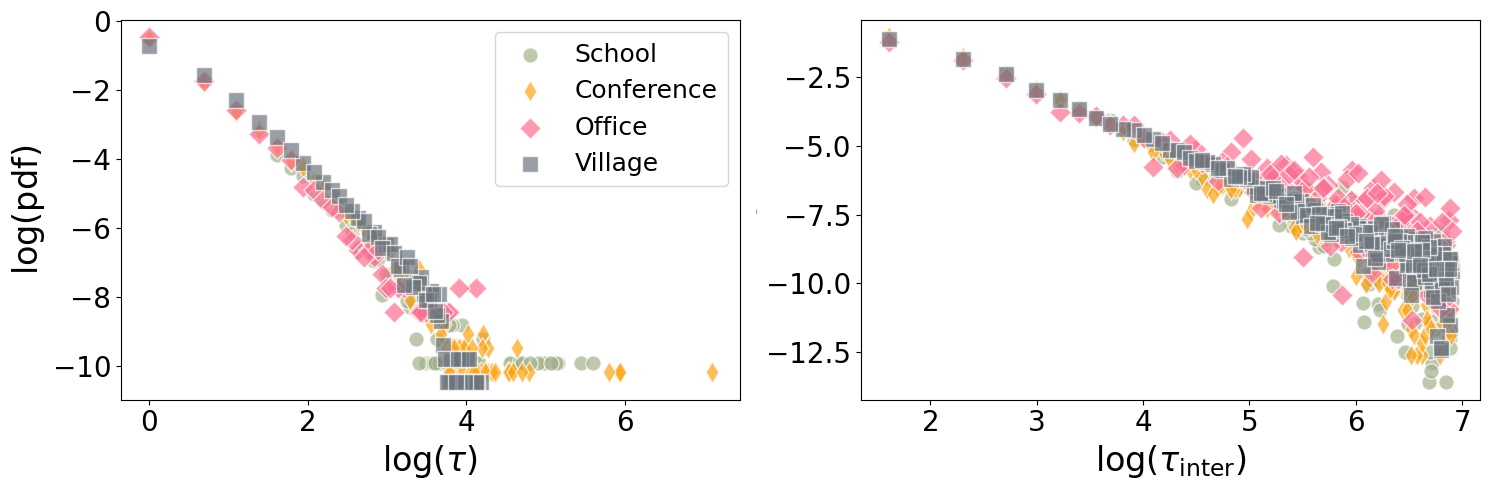

In [58]:
# PLOT
fig, ax = plt.subplots(1, 2, figsize = (15,5))

markers = ['o', 'd', 'D', 's']
colors = ['#a3b18a', '#fca311', '#fb6f92', '#6c757d']
allt = np.logspace(0, 5, 100)

for i, df in enumerate(dfv):
    
    Ddict = Counter(df.τ)
    x, y = np.array(list(Ddict.keys())), np.array(list(Ddict.values()))

    ax[0].scatter(np.log(x), np.log(y/np.sum(y)), marker = markers[i],s = 120, color = colors[i],
               edgecolor = 'white', alpha = .7, label = names[i])

    # keep only the interevent durations below 1000. Those that are above this number are likely associated
    # to different days
    X = intervals[i][intervals[i] < 1000]

    # aggregate in groups of 5
    X = (X/5).astype(int)*5
    
    Ddict = Counter(X)
    x, y = np.array(list(Ddict.keys())), np.array(list(Ddict.values()))

    ax[1].scatter(np.log(x), np.log(y/np.sum(y)), marker = markers[i],s = 120, color = colors[i],
               edgecolor = 'white', alpha = .7)
    
ax[0].tick_params(axis = 'both', which = 'major', labelsize = 20)
ax[1].tick_params(axis = 'both', which = 'major', labelsize = 20)

ax[0].legend(fontsize = 18)
ax[0].set_xlabel(r'${\rm log}(\tau)$', fontsize = 24)
ax[0].set_ylabel(r'${\rm log(pdf)}$', fontsize = 24)

ax[1].set_xlabel(r'${\rm log}(\tau_{\rm inter})$', fontsize = 24)
ax[1].set_ylabel(r'${\rm log(pdf)}$', fontsize = 0)

plt.tight_layout()

# uncomment to save
plt.savefig(f'{fig_directory}tnet_pl.pdf', bbox_inches = 'tight', dpi = 400)
plt.show();

## Burstiness

We now visualize the effect of burstiness. We take the `Conference` network and select one of its nodes $i$ and look at the temporal series of its interaction times. We then show a simple modeled quantity $\mathscr{Q}$ that increases by one for every contact $i$ has and decreases by the $3\%$ at each time stamp in which there is no interaction. 

We compare the results with sythetic generated data in which the temporal series is obtained from a Poisson process. The results show that, even though the number of contact events is very similar, $\mathscr{Q}$ reaches much larger values for the bursty dynamics.

In [59]:
# model parameters
x0 = 1
α = 0.03
T = 2500

########################################
########### POISSON DYNAMICS ###########
########################################

tv_Poi = [0]
flag = 0

# create the inter-event distribution
while flag == 0:
    newt = tv_Poi[-1] + np.random.poisson(7)
    tv_Poi.append(newt)
    if newt > T:
        flag = 1
    
tv_Poi = np.array(tv_Poi)

# generate the signal Q
Q_Poi = np.zeros(T)

for t in range(1, T):
    if t in tv_Poi:
        Q_Poi[t] = Q_Poi[t-1] + x0
    else:
        Q_Poi[t] = Q_Poi[t-1]*(1-α) 
        

# compute the burstiness
inter = (tv_Poi - np.roll(tv_Poi, 1))[1:]
s = np.std(inter)/np.mean(inter)
B = (s-1)/(s+1)
        
        
print('Poissonian case')
print(f'Number of events: {len(tv_Poi)}')
print(f'Burstiness: B = {B}')
print('\n')
        
########################################
############## REAL DATA ###############
########################################

# select only the contacts involving node index
df = copy(tij_conference)
index = 1467
idx = np.logical_or(df.i == index, df.j == index)
df = df[idx]

# generate the signal Q
Q = np.zeros(T)
tvr = np.sort(df.t.values)

for t in range(1, T):
    if t in tvr:
        Q[t] = Q[t-1] + x0
    else:
        Q[t] = Q[t-1]*(1-α) 
      
# compute the burstiness
inter = (df.t - np.roll(df.t, 1))[1:].values
s = np.std(inter)/np.mean(inter)

B = (s-1)/(s+1)
        
print('Real data')
print(f'Number of events: {len(df)}')
print(f'Burstiness: B = {B}')

Poissonian case
Number of events: 365
Burstiness: B = -0.44323796795867954


Real data
Number of events: 349
Burstiness: B = 0.6981801093753959


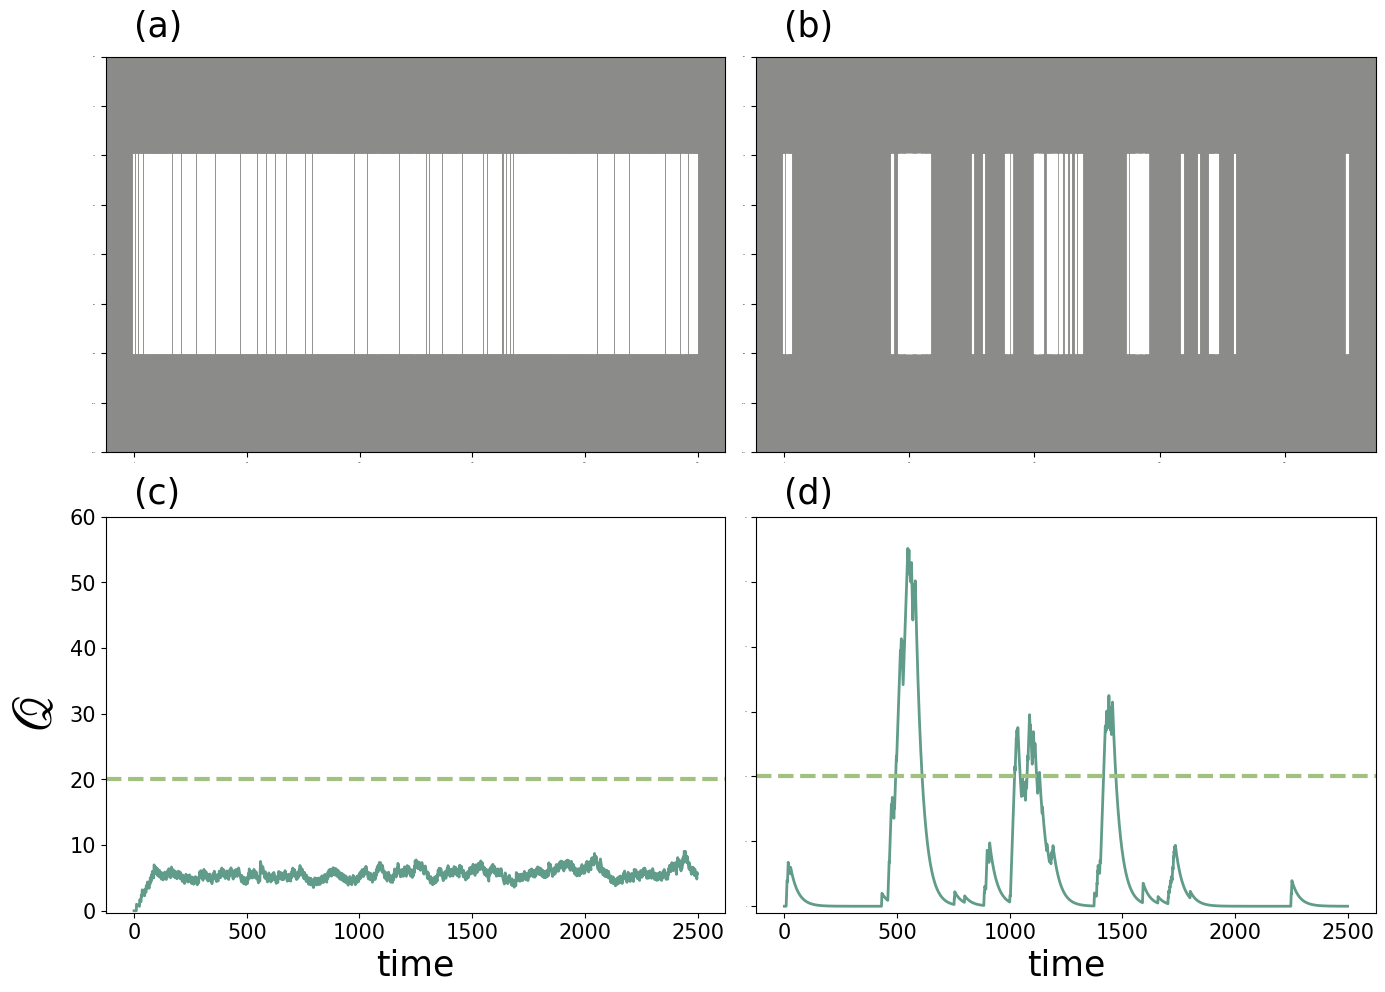

In [68]:
# PLOT

fig, ax = plt.subplots(2, 2, figsize = (14, 10))

for t in tv_Poi:
    if t < T:
        ax[0,0].plot([t, t], [0,1], color = 'white')
    
ax[0,0].set_facecolor('#8b8c89')
ax[0,0].set_ylim(-.5, 1.5)
ax[0,0].tick_params(axis = 'both', labelsize = 0)
ax[0,0].text(0, 1.6, '(a)', fontsize = 25)

######################################################

for t in df.t:
    if t < T:
        ax[0,1].plot([t, t], [0,1], color = 'white')
    
ax[0,1].set_facecolor('#8b8c89')
ax[0,1].set_ylim(-.5, 1.5)
ax[0,1].tick_params(axis = 'both', labelsize = 0)
ax[0,1].text(0, 1.6, '(b)', fontsize = 25)

#######################################################
        
ax[1, 0].plot(Q_Poi, linewidth = 2, color = '#619b8a')
ax[1,0].tick_params(axis = 'both', labelsize = 15)
ax[1,0].set_xlabel('time', fontsize = 25)
ax[1,0].set_ylabel(r'$\mathscr{Q}$', fontsize = 40)
ax[1,0].text(0, 62, '(c)', fontsize = 25)
ax[1,0].set_ylim(-0.3,60)
ax[1, 0].axhline(20, color = '#a1c181', linewidth = 3, linestyle = '--')

# ##################################################

ax[1,1].plot(Q, linewidth = 2, color = '#619b8a')
ax[1,1].tick_params(axis = 'x', labelsize = 15)
ax[1,1].tick_params(axis = 'y', labelsize = 0)
ax[1,1].set_xlabel('time', fontsize = 25)
ax[1,1].text(0, 62, '(d)', fontsize = 25)
ax[1,1].set_ylim(-1,60)
ax[1,1].axhline(20, color = '#a1c181', linewidth = 3, linestyle = '--')

plt.tight_layout()

# uncomment to save
plt.savefig(f'{fig_directory}tnet_burst.pdf', bbox_inches = 'tight', dpi = 400)
plt.show();